In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (precision_recall_fscore_support,precision_score, recall_score, 
                           confusion_matrix, accuracy_score,
                           f1_score, balanced_accuracy_score,
                           matthews_corrcoef,confusion_matrix)
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import glob

df1 = pd.read_csv("dataset/Physical dataset/phy_att_1.csv", sep="\t", encoding="utf-16")
df2 = pd.read_csv("dataset/Physical dataset/phy_att_2.csv", sep="\t", encoding="utf-16")
df3 = pd.read_csv("dataset/Physical dataset/phy_att_3.csv", sep="\t", encoding="utf-16")

df1.drop("Label_n",inplace=True,axis=1)
df2.drop("Lable_n",inplace=True,axis=1)
df3.drop("Label_n",inplace=True,axis=1)

# merge all datasets vertically
df = pd.concat([df1, df2, df3], axis=0)
df.drop("Time", inplace=True, axis=1)

# replace 'nomal' column to 'normal'
df["Label"] = df["Label"].apply(lambda x: "normal" if x == "nomal" else x)


In [2]:
# 1 if Label is not 'normal' else 0

df["Label_n"] = df["Label"].apply(lambda x: 1 if x != "normal" else 0)

# shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,Tank_1,Tank_2,Tank_3,Tank_4,Tank_5,Tank_6,Tank_7,Tank_8,Pump_1,Pump_2,...,Valv_15,Valv_16,Valv_17,Valv_18,Valv_19,Valv_20,Valv_21,Valv_22,Label,Label_n
0,1,950,3404,847,445,383,0,26,False,False,...,True,False,True,False,False,True,False,True,normal,0
1,5,1607,175,0,87,414,249,0,True,False,...,False,False,True,False,False,True,False,False,normal,0
2,1314,1878,113,0,690,0,0,0,False,False,...,False,False,True,False,False,False,False,False,normal,0
3,4,1786,323,0,357,449,0,0,True,False,...,False,False,True,False,False,True,False,False,normal,0
4,310,947,223,374,579,248,0,0,False,False,...,True,False,True,True,False,True,False,False,normal,0


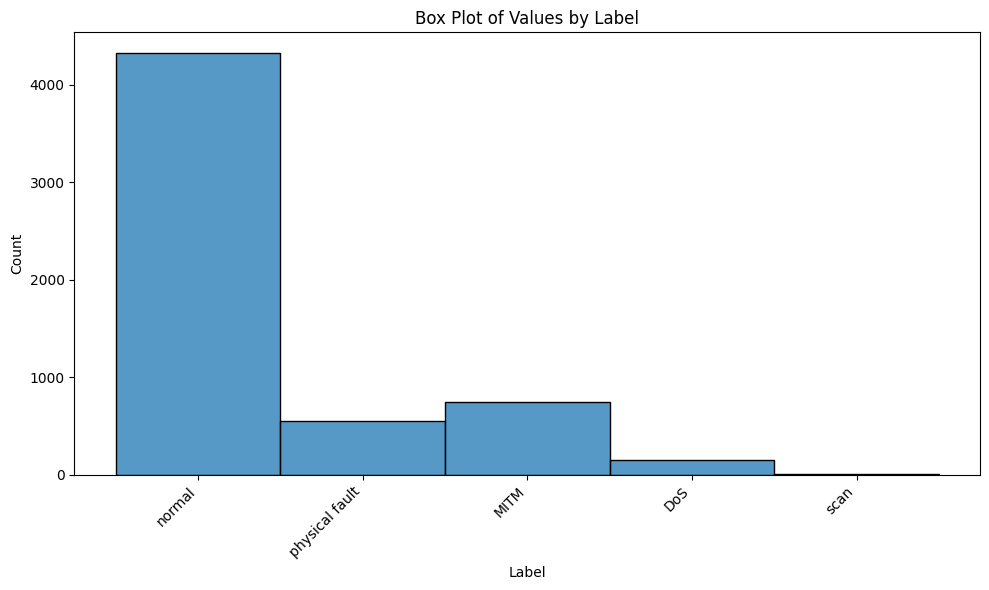

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(x='Label', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Box Plot of Values by Label')
plt.tight_layout()
plt.show()


In [4]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import time

# Prepare data
X = df.drop(["Label", "Label_n"], axis=1)
y = df["Label_n"]

# Define models to test
models = {
    'KNN': KNeighborsClassifier(n_neighbors=10),
    'CART': DecisionTreeClassifier(random_state=15),
    'Random Forest': RandomForestClassifier(random_state=15, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=15),
    'CatBoost': CatBoostClassifier(random_state=15, verbose=False),
    'MLP': MLPClassifier(random_state=15, max_iter=1000),
    "SVM": SVC(random_state=15, kernel="rbf"),
    "Naive Bayes": GaussianNB()
}

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=15)

for model_name, model in models.items():
    # Initialize lists to store metrics
    metrics = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    start = time.time()
    
    # Perform k-fold cross validation
    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train and evaluate model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        report = classification_report(y_test, y_pred, output_dict=True)
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(report['1']['precision'])
        metrics['recall'].append(report['1']['recall'])
        metrics['f1'].append(report['1']['f1-score'])

    # Print results
    print(f"\nModel: {model_name} ran on {len(metrics['accuracy'])} folds in {time.time() - start:.2f} seconds")
    for metric in metrics:
        print(f'Average {metric.title()}: {np.mean(metrics[metric]):.2f} ± {np.std(metrics[metric]):.2f}')


Model: KNN ran on 5 folds in 0.76 seconds
Average Accuracy: 0.97 ± 0.01
Average Precision: 0.96 ± 0.02
Average Recall: 0.90 ± 0.02
Average F1: 0.93 ± 0.02

Model: CART ran on 5 folds in 0.20 seconds
Average Accuracy: 0.97 ± 0.01
Average Precision: 0.94 ± 0.02
Average Recall: 0.94 ± 0.02
Average F1: 0.94 ± 0.01

Model: Random Forest ran on 5 folds in 2.64 seconds
Average Accuracy: 0.99 ± 0.00
Average Precision: 0.99 ± 0.01
Average Recall: 0.96 ± 0.01
Average F1: 0.97 ± 0.01

Model: XGBoost ran on 5 folds in 2.37 seconds
Average Accuracy: 0.99 ± 0.00
Average Precision: 0.98 ± 0.01
Average Recall: 0.96 ± 0.01
Average F1: 0.97 ± 0.01

Model: CatBoost ran on 5 folds in 22.93 seconds
Average Accuracy: 0.98 ± 0.00
Average Precision: 0.98 ± 0.01
Average Recall: 0.96 ± 0.01
Average F1: 0.97 ± 0.01

Model: MLP ran on 5 folds in 6.03 seconds
Average Accuracy: 0.88 ± 0.03
Average Precision: 0.73 ± 0.10
Average Recall: 0.86 ± 0.06
Average F1: 0.79 ± 0.04

Model: SVM ran on 5 folds in 3.82 seconds
